eta = 0.1, epsilon = 1.569736287230799e-05
eta = 0.1, epsilon = 1.3882309317760887e-05
eta = 0.1, epsilon = 6.023182416988781e-06
eta = 0.1, epsilon = 1.3122745856650586e-07
eta = 0.1, epsilon = 1.5651355485865846e-09
eta = 0.2, epsilon = 0.00032964677640603534
eta = 0.2, epsilon = 0.00028821432307135067
eta = 0.2, epsilon = 0.00011618018582199733
eta = 0.2, epsilon = 2.0106531124001954e-06
eta = 0.2, epsilon = 2.2615364534841515e-08
eta = 0.3, epsilon = 0.002282382340691381
eta = 0.3, epsilon = 0.001962082346308464
eta = 0.3, epsilon = 0.0007138322991723641
eta = 0.3, epsilon = 1.019144061738501e-05
eta = 0.3, epsilon = 1.3028139547317153e-07
eta = 0.3, epsilon = 2.2484915907425015e-09
eta = 0.4, epsilon = 0.01042659486189437
eta = 0.4, epsilon = 0.008728737803494716
eta = 0.4, epsilon = 0.002735780211060853
eta = 0.4, epsilon = 3.5297658723090666e-05
eta = 0.4, epsilon = 5.946485649616977e-07
eta = 0.4, epsilon = 1.3829087867194564e-08
eta = 0.5, epsilon = 0.03978052126200275
eta = 0

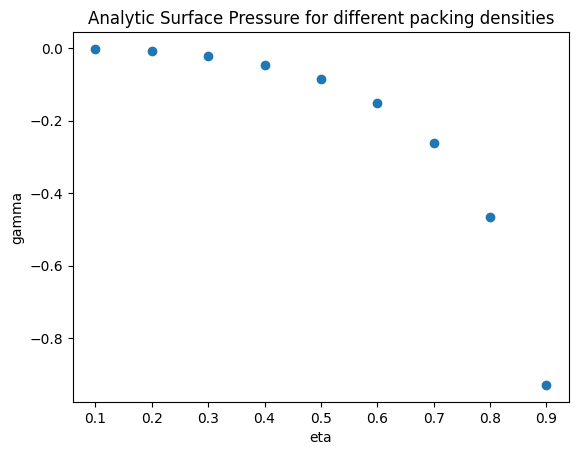

eta = 0.1, epsilon = 1.569736287230799e-05
eta = 0.1, epsilon = 1.3882309317760887e-05
eta = 0.1, epsilon = 6.023182416988781e-06
eta = 0.1, epsilon = 1.3122745856650586e-07
eta = 0.1, epsilon = 1.5651355485865846e-09
[0.         0.         0.         0.03569849 0.0344335  0.03321383
 0.03329923 0.03333832 0.0333343  0.03333316 0.03333331 0.03333334
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]


In [1]:
from matplotlib.widgets import Lasso
import  numpy as np
import matplotlib.pyplot as plt
import math
#import pandas as pd

#constants of the system
alpha_min = 10e-4
alpha_max = 10e-2
L = 3
eta_0 = 0.1
rho_b = eta_0/L
border = 3
mu_id = np.log(rho_b)
mu_ex = -L*np.log(1-L*rho_b) + (L-1)*np.log(1-(L-1)*rho_b)
mu = mu_id+mu_ex

#initialize
V_ex = np.ones(1024)
V_ex[:border] = 0
V_ex[-border:] = 0
rho_0 = np.ones(1024)*rho_b*V_ex
rho = np.ndarray.copy(rho_0)


def calc_mu_ex(rho, L):#should be correct
    mu_ex = np.zeros(len(rho))
    for s in range(len(rho)):
        for i in range(s,s+L):
            mu_ex[s] += -np.log(1-np.sum(rho[i-L+1:i+1]))
        for i in range(s+1,s+L):
            mu_ex[s] += np.log(1-np.sum(rho[i-L+1:i]))
    return mu_ex


def update_rho(rho, mu, alpha, eps_old, L): #should be right
    rho_new = np.exp(mu-calc_mu_ex(rho, L))*V_ex
    alpha, eps = calc_alpha(alpha, eps_old, rho_new, rho)
    next_rho = (1-alpha)*rho + alpha*rho_new
    return next_rho, eps, alpha


def calc_alpha(alpha, eps_old, rho, rho_old):
    eps = np.sum((rho - rho_old)**2)
    if eps<eps_old:
        alpha = np.minimum(alpha_max, 1.1*alpha)
    else:
        alpha = np.maximum(alpha_min, alpha/5.0)
    return alpha, eps


def omega(rho, mu):
    n_1 = np.zeros(len(rho))
    n_0 = np.zeros(len(rho))
    for s in range(len(rho)):
        n_1[s] = np.sum(rho[s-L+1:s+1])
        n_0[s] = np.sum(rho[s-L+1:s])
    rho_fluid = rho[border:-border]
    n_1_fluid = n_1[border:-border]
    n_0_fluid = n_0[border:-border]
    return np.sum(rho_fluid*(np.log(rho_fluid)-1)+n_1_fluid+(1-n_1_fluid)*np.log(1-n_1_fluid) - n_0_fluid-(1-n_0_fluid)*np.log(1-n_0_fluid)-mu*rho_fluid)


def omega_test(rho, mu):
    n_1 = np.zeros(len(rho))
    n_0 = np.zeros(len(rho))
    for s in range(len(rho)):
        for t in range(s-L+1, s+1):
            n_1[s] += rho[t]
        #n_1[s] = np.sum(rho[s-L+1:s+1])
        for t in range(s-L+1, s):
            n_0[s] += rho[t]
        #n_0[s] = np.sum(rho[s-L+1:s])
    rho_fluid = rho[border:-border]
    #print('rho_fluid:')
    #print(rho_fluid)
    n_1_fluid = n_1[border:-border]
    n_0_fluid = n_0[border:-border]
    res = 0
    for s in range(len(rho_fluid)):
        res += rho_fluid[s]*(np.log(rho_fluid[s])-1)+n_1_fluid[s]+(1-n_1_fluid[s])*np.log(1-n_1_fluid[s]) - n_0_fluid[s]-(1-n_0_fluid[s])*np.log(1-n_0_fluid[s])-mu*rho_fluid[s]
    return res# np.sum(rho_fluid*(np.log(rho_fluid)-1)+n_1_fluid+(1-n_1_fluid)*np.log(1-n_1_fluid) - n_0_fluid-(1-n_0_fluid)*np.log(1-n_0_fluid)-mu*rho_fluid)


def p_test(rho, mu):
    return -omega_test(rho, mu)/(len(rho)-2*border)


def gamma_test(rho, rho_0, mu):
    #print('rho & rho_0')
    #print(rho[:20])
    #print(rho_0[:20])
    return (omega_test(rho, mu)-omega_test(rho_0, mu))/2


def gamma(rho, rho_0, mu):
    #print('rho & rho_0')
    #print(rho[:20])
    #print(rho_0[:20])
    return (omega(rho, mu)-omega(rho_0, mu))/2


def adsorption(rho, rho_0):
    x = rho-rho_0
    return np.sum(x[border:-border])/2


def p(rho, mu):
    return -omega(rho, mu)/(len(rho)-2*border)


def iterate(eta_0, L):
    rho_b = eta_0/L
    mu_id = np.log(rho_b)
    mu_ex = -L*np.log(1-L*rho_b) + (L-1)*np.log(1-(L-1)*rho_b)
    mu = mu_id+mu_ex
    #initialize
    V_ex = np.ones(1024)
    V_ex[:border] = 0
    V_ex[-border:] = 0
    rho_0 = np.ones(1024)*rho_b*V_ex
    rho = rho_0
    j = 0
    eps_0 = 0
    eps = eps_0
    alpha = alpha_min
    while j<100:
        rho, eps, alpha = update_rho(rho, mu, alpha, eps)
        j+=1
    return rho, rho_0, mu


def derive_gamma (rho_0, delta):
    L = 3
    eta_plus = (rho_0 + delta) * L
    eta_minus = (rho_0 - delta) * L
    
    rho_plus, rho_0_plus, mu_plus = iterate (eta_plus, L)
    rho_minus, rho_0_minus, mu_minus = iterate (eta_minus, L)
    return - (gamma(rho_plus, rho_0_plus, mu_plus) - gamma (rho_minus, rho_0_minus, mu_minus))/(mu_plus - mu_minus)


#print(derive_gamma(rho_b, 0.001))

j = 0
eps_0 = 0
eps = eps_0
alpha = alpha_min




def plot(L):

  for i in range (1,2):

    alpha_min = 10e-4
    alpha_max = 10e-2

    j = 0
    eps_0 = 0
    eps = eps_0
    alpha = alpha_min

    #constants of the system

#    L = 3
    eta_0 = i/10
    rho_b = eta_0/L
    border = 3
    mu_id = np.log(rho_b)
    mu_ex = -L*np.log(1-L*rho_b) + (L-1)*np.log(1-(L-1)*rho_b)
    mu = mu_id+mu_ex

    #initialize
    V_ex = np.ones(1024)
    V_ex[:border] = 0
    V_ex[-border:] = 0
    rho_0 = np.ones(1024)*rho_b*V_ex
    rho = np.ndarray.copy(rho_0)

  
    while True:
        rho, eps, alpha = update_rho(rho, mu, alpha, eps, L)
        if j%20 == 0:
            print("eta = {}, epsilon = {}".format(eta_0, eps))
            
        j = j+1
        if math.isnan(eps):
          break
        if i >= 7:
          if eps < 10E-4:
            break
        if i >= 6:
          if eps < 10E-6:
            break
        elif eps < 10E-10:
            break

    plt.scatter(range(30), rho[:30])
  plt.legend(["eta = {}".format(i/10) for i in range(1,2)], loc='upper right')
  plt.ylabel("rho")
  plt.xlabel("Position")
  plt.title("Density Profiles for L = {}".format(L))
  plt.savefig('test')   
  plt.show()


def plot_gamma(L):

  gamma_anas = []


  for i in range (1,10):


    alpha_min = 10e-4
    alpha_max = 10e-2

    j = 0
    eps_0 = 0
    eps = eps_0
    alpha = alpha_min

    #constants of the system

#    L = 3
    eta_0 = i/10
    rho_b = eta_0/L
    border = 3
    mu_id = np.log(rho_b)
    mu_ex = -L*np.log(1-L*rho_b) + (L-1)*np.log(1-(L-1)*rho_b)
    mu = mu_id+mu_ex

    #initialize
    V_ex = np.ones(1024)
    V_ex[:border] = 0
    V_ex[-border:] = 0
    rho_0 = np.ones(1024)*rho_b*V_ex
    rho = np.ndarray.copy(rho_0)

  
    while True:
        rho, eps, alpha = update_rho(rho, mu, alpha, eps, L)
        if j%20 == 0:
            print("eta = {}, epsilon = {}".format(eta_0, eps))
            
        j = j+1
        if math.isnan(eps):
          break
        if i >= 7:
          if eps < 10E-4:
            break
        if i >= 6:
          if eps < 10E-6:
            break
        elif eps < 10E-10:
            break

    pr = p_test(rho_0, mu)
    gamma_ana = mu_ex/2-(2*L-1)*pr/2
    gamma_anas.append(gamma_ana)
  plt.scatter([i/10 for i in range(1,10)], gamma_anas)

  #plt.legend(["eta = {}".format(i/10) for i in range(1,2)], loc='upper right')
  plt.ylabel("gamma")
  plt.xlabel("eta")
  plt.title("Analytic Surface Pressure for different packing densities")
  plt.savefig('test')   
  plt.show()

#plot(3)
plot_gamma(3)

while True:
        rho, eps, alpha = update_rho(rho, mu, alpha, eps, L)
        if j%20 == 0:
            print("eta = {}, epsilon = {}".format(eta_0, eps))
            
        j = j+1

        if eps < 10E-10:
            break


print(rho[:30])

#rho_dat = np.loadtxt("L3_rhodat.txt")
#rho_ext = rho_dat[:,1]
#print(rho_ext[0:20])
#rho = rho_ext
#rho_b = 3.33333333e-02
#rho_0 = np.ones(206)*rho_b
#rho_0[:3] = 0
#rho_0[-3:] = 0
#border = 3


#muexpp = calc_mu_ex(rho_0)
#print("omega " + str(omega_test(rho, mu)))
#print('analytic pressure: ' + str(np.log(1-(L-1)*rho_b)-np.log(1-L*rho_b)))
#pr = p_test(rho_0, mu)
#print('Pressure ' + str(pr))
#print('gamma(nach 2.22): ' + str((mu_ex/2-(2*L-1)*pr/2)))#passt!
#print('gamma(nach 2.21 rechts) ' + str((omega_test(rho, mu)+pr*200)/2)) #passt nicht OMEGA?
#print('Gammafunktion ' + str(gamma_test(rho, rho_0, mu)))#passt nicht :(
#print(rho[-20:])
#print(rho[:20])
#plt.plot(rho)
#plt.show()